converged in 168 iters


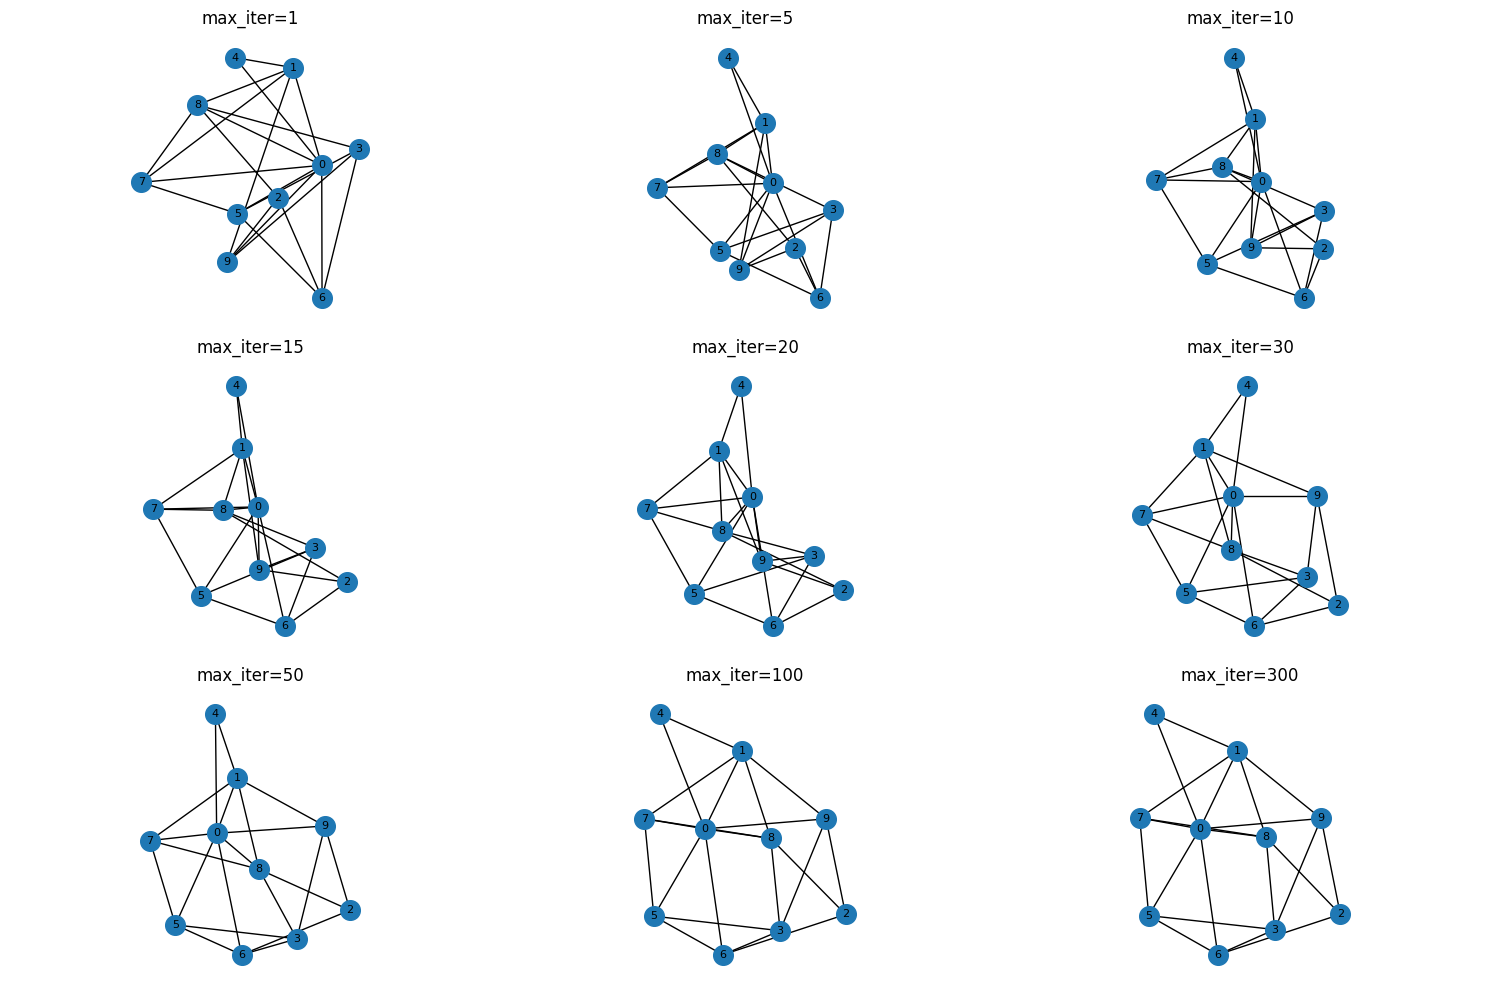

In [21]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def stress_majorization_layout(G, dim=2, max_iter=100, tol=1e-4, seed=None):
    """
    Stress majorization layout (Gasner et al.) for graph G.
    Returns a dict mapping node -> position (dim-dimensional).
    """
    if seed is not None:
        np.random.seed(seed)

    nodes = list(G.nodes())
    n = len(nodes)
    idx = {u:i for i,u in enumerate(nodes)}

    path_len = dict(nx.all_pairs_shortest_path_length(G))
    D = np.zeros((n,n), dtype=float)
    W = np.zeros((n,n), dtype=float)
    for u in nodes:
        i = idx[u]
        for v, d in path_len[u].items():
            j = idx[v]
            if i != j and d > 0:
                D[i,j] = d
                W[i,j] = 1.0 / (d*d) 

    X = np.random.randn(n, dim)


    for it in range(max_iter):
        X_old = X.copy()

        for i in range(n):

            mask = np.arange(n) != i
            w = W[i,mask]                    # shape (n-1,)
            vs = X[mask]                     # shape (n-1,dim)
            ds = D[i,mask].reshape(-1,1)     # shape (n-1,1)

            diff = (X[i] - vs)               # shape (n-1,dim)
            norms = np.linalg.norm(diff, axis=1, keepdims=True)
            norms[norms < 1e-6] = 1e-6        

            # 論文の式 (2) の中身： x_v + d_uv * (x_u - x_v)/||x_u - x_v||
            term = vs + ds * (diff / norms)

            # p_u = ∑_v w_uv * term_v  / ∑_v w_uv
            X[i] = (w.reshape(-1,1) * term).sum(axis=0) / (w.sum() + 1e-6)

        # 収束判定
        if np.linalg.norm(X - X_old) < tol:
            print(f"converged in {it+1} iters")
            break


    return {nodes[i]: X[i] for i in range(n)}


if __name__ == "__main__":
    # grid graph
    # G = nx.grid_2d_graph(5,6)
    # star graph
    # G = nx.star_graph(10)
    # complete graph
    # G = nx.complete_graph(10)
    # cycle graph
    # G = nx.cycle_graph(10)
    # random graph
    G = nx.erdos_renyi_graph(10, 0.5)
    # large random graph
    # G = nx.erdos_renyi_graph(30, 0.01)



    # ノードを整数に変換
    G = nx.convert_node_labels_to_integers(G)

    max_iters = [1, 5, 10, 15, 20, 30, 50, 100, 300]
    plt.figure(figsize=(15, 10))
    for i, mi in enumerate(max_iters, 1):
        pos_iter = stress_majorization_layout(G, dim=2, max_iter=mi, tol=1e-5, seed=42)
        plt.subplot(3, 3, i)
        nx.draw(G, pos_iter, with_labels=True, node_size=200, font_size=8)
        plt.title(f"max_iter={mi}")
        plt.axis('equal')
    plt.tight_layout()
    plt.show()
